In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
count_data = np.array([
    13,  24,   8,  24,   7,  35,  14,  11,  15,  11,  22,  22,  11,  57,  
    11,  19,  29,   6,  19,  12,  22,  12,  18,  72,  32,   9,   7,  13,  
    19,  23,  27,  20,   6,  17,  13,  10,  14,   6,  16,  15,   7,   2,  
    15,  15,  19,  70,  49,   7,  53,  22,  21,  31,  19,  11,  18,  20,  
    12,  35,  17,  23,  17,   4,   2,  31,  30,  13,  27,   0,  39,  37,   
    5,  14,  13,  22,
])

n_count_data = len(count_data)

days = np.arange(0, n_count_data)

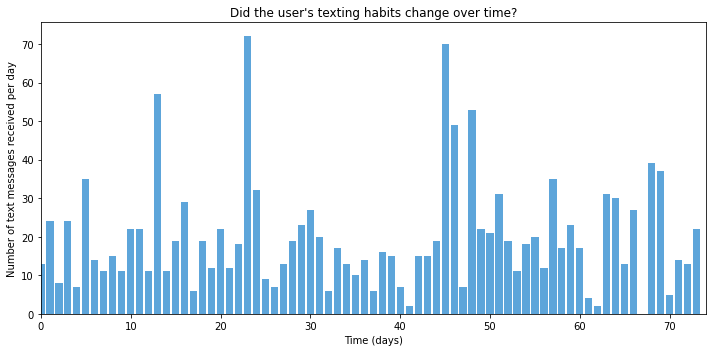

In [5]:
plt.figure(figsize=(10, 5))
plt.bar(days, count_data, color="#5DA5DA")
plt.xlabel("Time (days)")
plt.ylabel("Number of text messages received per day")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

plt.tight_layout()
plt.savefig('data.pdf')

In [6]:
model = pm.Model() 
    
with model:
    
    alpha = 1.0 / np.mean(count_data)
    
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
    lambda_ = pm.math.switch(tau > days, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)

In [9]:
with model:
    
    trace = pm.sample(2000);

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:03<00:00, 1554.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [10]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

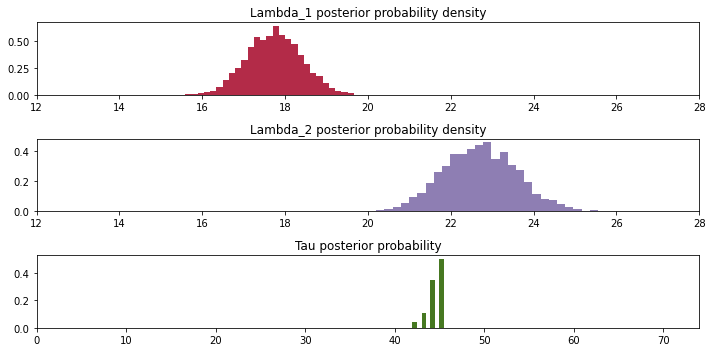

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(10, 5))

axes[0].hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#A60628", density=True)
axes[0].set_xlim(12, 28)
axes[0].set_title('Lambda_1 posterior probability density')

axes[1].hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#7A68A6", density=True)
axes[1].set_xlim(12, 28)
axes[1].set_title('Lambda_2 posterior probability density')

w = 1.0 / len(tau_samples) * np.ones_like(tau_samples)
axes[2].hist(tau_samples, bins=n_count_data, alpha=1, color="#467821", weights=w, width=0.5)
axes[2].set_xlim(0, n_count_data)
axes[2].set_title('Tau posterior probability')

plt.tight_layout()
plt.savefig('distributions.pdf')

In [12]:
N = len(tau_samples)
expected_texts_per_day = np.zeros(n_count_data)
for day in range(n_count_data):
    ix = day < tau_samples
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N

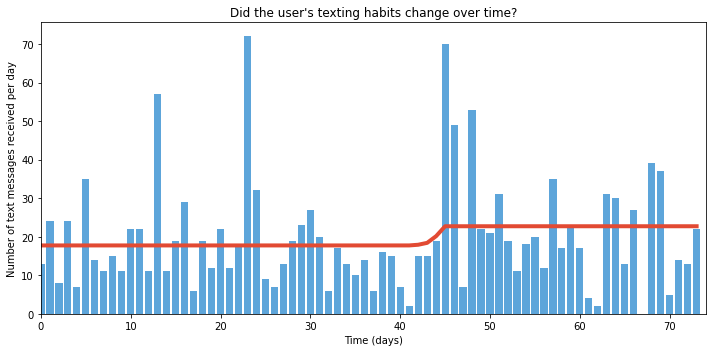

In [13]:
plt.figure(figsize=(10, 5))
plt.bar(days, count_data, color="#5DA5DA")
plt.plot(days, expected_texts_per_day, lw=4, color="#E24A33")
plt.xlabel("Time (days)")
plt.ylabel("Number of text messages received per day")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

plt.tight_layout()
plt.savefig('results.pdf')